## Setup

In [1]:
#@markdown #**Verificar tipo de GPU**

#@markdown ---




#@markdown V100 = Excelente! (disponível apenas no Colab Pro)

#@markdown P100 = Muito boa.

#@markdown T4 = OK.

#@markdown K80 = Melhor reiniciar.

#@markdown P4 = Impossível!

#@markdown ---

print("GPU:")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('not found') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\nRAM:")
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

GPU:
Thu Mar 21 01:44:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

In [2]:
#!pip install setuptools==66
#!pip install d2l==1.0.0-beta0

!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 12.0 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_cv
from sklearn.model_selection import train_test_split
from PIL import Image

seeder = 123
#from d2l import tensorflow as d2l

Using TensorFlow backend


In [4]:
print("Versão TF: ", tf.__version__)
print("Eager Mode: ", tf.executing_eagerly())
print("TF Functions running eargerly: ", tf.config.functions_run_eagerly())
print("Hub version: ", hub.__version__)
print("Keras_cv version:", keras_cv.__version__)
print("GPU", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT available")

Versão TF:  2.15.0
Eager Mode:  True
TF Functions running eargerly:  False
Hub version:  0.16.1
Keras_cv version: 0.8.2
GPU available


# Collected data

The data was collected by scrapping google images. They consist of 3 different characters from the game League of Legends.
After the fine-tuning, the model will be able to predict which character is depicted in the image.

## Download the dataset
(Private kaggle dataset that I created from the scrapped images)

In [5]:
#(https://www.kaggle.com/general/74235)

# 1. Instalar utilitário de linha de comando
!pip install -q kaggle

# 2. Upar no colab a chave da api da conta do kaggle (kaggle.json) e colocar em ~/.kaggle/kaggle.json
!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json

# 3. Permissão de leitura
!chmod 600 ~/.kaggle/kaggle.json

# 4. Baixar o dataset pelo link da api do dataset (pegar na página do dataset)
!kaggle datasets download -d alundra/league-of-legends-champions-images

# 5. Descompactar
!mkdir dataset
!unzip league-of-legends-champions-images.zip -d league-dataset

 99% 302M/306M [00:03<00:00, 109MB/s]
100% 306M/306M [00:03<00:00, 87.4MB/s]
Archive:  league-of-legends-champions-images.zip
  inflating: league-dataset/aurelion sol/1.jpg  
  inflating: league-dataset/aurelion sol/10.jpg  
  inflating: league-dataset/aurelion sol/100.jpg  
  inflating: league-dataset/aurelion sol/101.jpg  
  inflating: league-dataset/aurelion sol/102.jpg  
  inflating: league-dataset/aurelion sol/103.jpg  
  inflating: league-dataset/aurelion sol/104.jpg  
  inflating: league-dataset/aurelion sol/105.jpg  
  inflating: league-dataset/aurelion sol/106.jpg  
  inflating: league-dataset/aurelion sol/108.jpg  
  inflating: league-dataset/aurelion sol/109.jpg  
  inflating: league-dataset/aurelion sol/11.jpg  
  inflating: league-dataset/aurelion sol/110.jpg  
  inflating: league-dataset/aurelion sol/112.jpg  
  inflating: league-dataset/aurelion sol/113.jpg  
  inflating: league-dataset/aurelion sol/114.jpg  
  inflating: league-dataset/aurelion sol/115.jpg  
  inflating

## Making the tensorflow dataset with augmentation



In [6]:
IMAGE_SIZE = (512,512)
BATCH_SIZE = 16
data_dir = "/content/league-dataset" # Diretório das imagens

# Construir dataset a partir do diretório (Labels serão os nomes dos subdiretórios)
# https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=.20,
            subset=subset, # "training" or "validation"
            label_mode="categorical",
            # Seed needs to provided when using validation_split and shuffle = True.
            # A fixed seed is used so that the validation set is stable across runs.
            seed=123,
            image_size=IMAGE_SIZE,
            batch_size=1
        )

train_ds = build_dataset("training")
class_names = np.array(tuple(train_ds.class_names))
print("Classes:", class_names)

train_size = train_ds.cardinality().numpy()
print("Train size: ", train_size)

train_ds = train_ds.unbatch().batch(BATCH_SIZE) # Fazer batch das imagens
train_ds = train_ds.repeat() # Repetir?

normalization_layer = tf.keras.layers.Rescaling(1. / 255) # Normalizar as imagens para valores de 0 a 1

preprocessing_model = tf.keras.Sequential([normalization_layer]) # Modelo para pré-processamento das imagens

# Fazer data augmentation nas imagens
do_data_augmentation = True
if do_data_augmentation:
    #preprocessing_model.add(tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0.0, 1.0)))
    preprocessing_model.add(tf.keras.layers.RandomRotation(40))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))

    # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
    # image sizes are fixed when reading, and then a random zoom is applied.
    # If all training inputs are larger than image_size, one could also use
    # RandomCrop with a batch size of 1 and rebatch later.
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# Fazer pré-processamento no dataset
train_ds = train_ds.map(
    lambda images, labels: (preprocessing_model(images), labels)
)
#train_ds = train_ds.prefetch(BATCH_SIZE) # <<<

# Mesma coisa com o dataset de validação, mas sem o data augmentation.
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(
    lambda images, labels: (normalization_layer(images), labels)
)
#val_ds = val_ds.repeat()
#val_ds = val_ds.prefetch(BATCH_SIZE) # <<<

Found 807 files belonging to 3 classes.
Using 646 files for training.
Classes: ['aurelion sol' 'kindred' 'teemo']
Train size:  646
Found 807 files belonging to 3 classes.
Using 161 files for validation.


### Check some images from the dataset
(.take() remove as imagens do dataset, então depois de visualizar deve-se executar a célula acima novamente)

<Figure size 3000x1200 with 0 Axes>

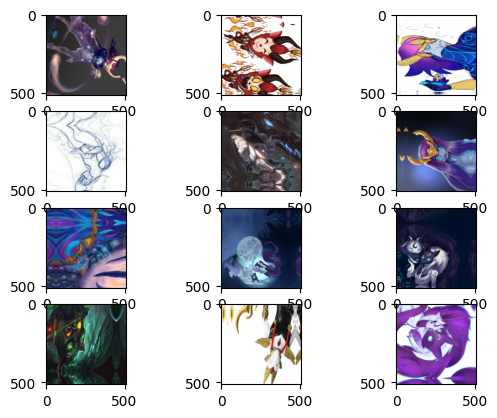

In [7]:
plt.figure(figsize=(30,12))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,3)

i=0
for img,label in train_ds.take(3):
  #print(img.shape) # (batch?, altura, largura, canaisRGB)
  #print(label)
  axarr[0][i].imshow(img[0])
  axarr[1][i].imshow(img[1])
  axarr[2][i].imshow(img[2])
  axarr[3][i].imshow(img[3])
  i+=1

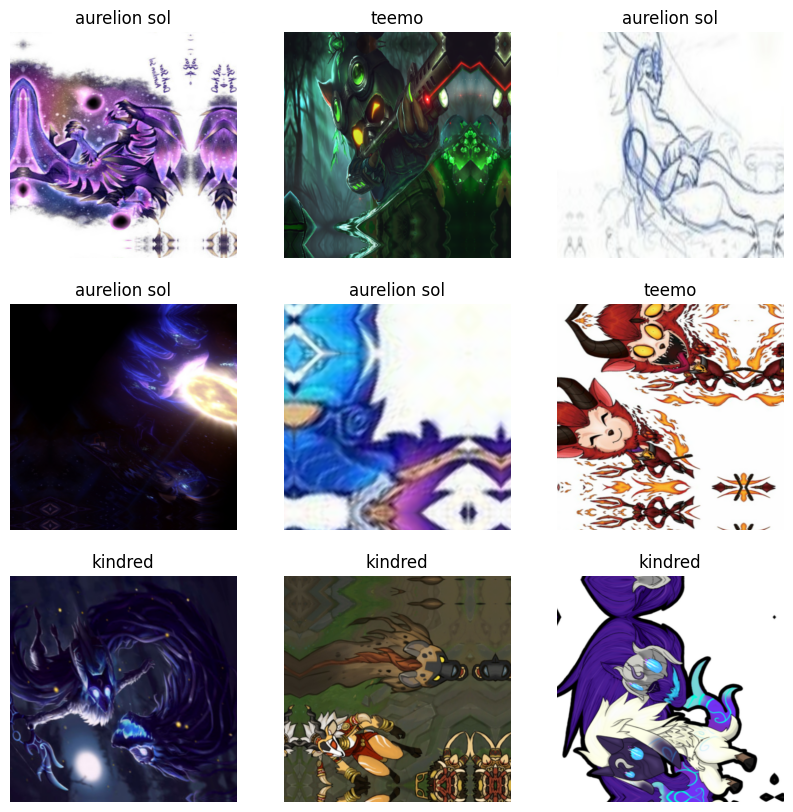

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.title(class_names[tf.where(labels[i])[0][0]])
    plt.axis("off")


# Transfer learning
https://www.tensorflow.org/tutorials/images/transfer_learning

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial.

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics.

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

## MobileNetV2
MobileNetV2 is a general architecture and can be used for multiple use cases. Depending on the use case, it can use different input layer size and different width factors. This allows different width models to reduce the number of multiply-adds and thereby reduce inference cost on mobile devices.

MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

The number of parameters and number of multiply-adds can be modified by using the alpha parameter, which increases/decreases the number of filters in each layer. By altering the image size and alpha parameter, all 22 models from the paper can be built, with ImageNet weights provided.

In [9]:
IMG_SIZE = (512, 512)
IMG_SHAPE = IMG_SIZE + (3,)
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    pooling="max"
)

#modelo.summary()
# Total params: 2,257,984
# Trainable params: 2,223,872
# Non-trainable params: 34,112

9406464/9406464 [==============================] - 0s 0us/step


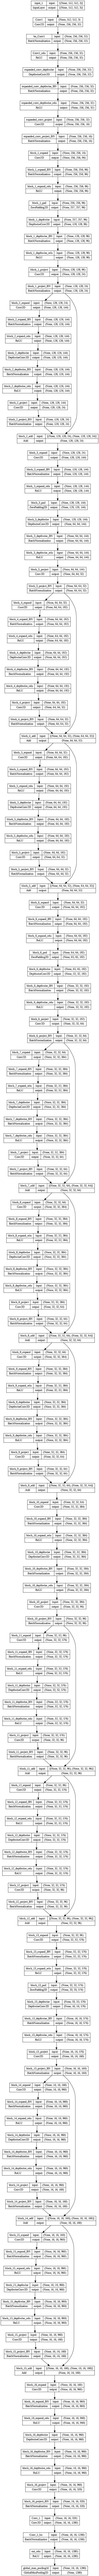

In [10]:
tf.keras.utils.plot_model(model=mobilenet, show_shapes=True, dpi=76)

In [11]:
mobilenet.__class__

keras.src.engine.functional.Functional

### Fine-tune new layers
First train the classification layer, with the pre-trained network frozen

In [12]:
print(mobilenet.trainable)
mobilenet.trainable = False
print(mobilenet.trainable)
mobilenet.summary()
# >> Total params: 2,257,984
# >> Trainable params: 0
# >> Non-trainable params: 2,257,984

True
False
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 256, 256, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 256, 256, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 256, 256, 32)         0         

#### Using keras.Sequential to build the model

In [13]:
modelo_novo = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        3,
        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seeder),
        kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )
])
#modelo_novo.build((None,)+IMAGE_SIZE+(3,))
modelo_novo.summary()
# >> Total params: 2,261,827
# >> Trainable params: 3,843
# >> Non-trainable params: 2,257,984

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


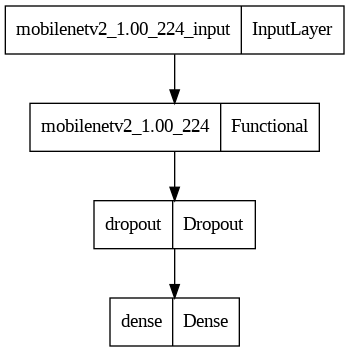

In [14]:
tf.keras.utils.plot_model(modelo_novo, "mobilenet fine-tune.png")

In [15]:
lr_classification_head = 0.001
modelo_novo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_classification_head),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
print(len(modelo_novo.trainable_variables))

2


In [16]:
loss0, accuracy0 = modelo_novo.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 9s 399ms/step - loss: 1.1819 - accuracy: 0.3727
initial loss: 1.18
initial accuracy: 0.37


In [17]:
# As you are training a much larger model and want to readapt the pretrained weights, it is
# important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
total_epochs = 20

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = modelo_novo.fit(
    train_ds,
    epochs=total_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps
)

Epoch 1/20
40/40 [==============================] - 95s 2s/step - loss: 1.5857 - accuracy: 0.4859 - val_loss: 0.8991 - val_accuracy: 0.5875
Epoch 2/20
40/40 [==============================] - 99s 2s/step - loss: 1.0221 - accuracy: 0.6175 - val_loss: 0.6110 - val_accuracy: 0.7375
Epoch 3/20
40/40 [==============================] - 89s 2s/step - loss: 0.6831 - accuracy: 0.7286 - val_loss: 0.4274 - val_accuracy: 0.7937
Epoch 4/20
40/40 [==============================] - 84s 2s/step - loss: 0.6687 - accuracy: 0.7302 - val_loss: 0.5117 - val_accuracy: 0.8000
Epoch 5/20
40/40 [==============================] - 76s 2s/step - loss: 0.7819 - accuracy: 0.7063 - val_loss: 0.3672 - val_accuracy: 0.8438
Epoch 6/20
40/40 [==============================] - 81s 2s/step - loss: 0.5759 - accuracy: 0.7714 - val_loss: 0.4483 - val_accuracy: 0.8250
Epoch 7/20
40/40 [==============================] - 72s 2s/step - loss: 0.5705 - accuracy: 0.7794 - val_loss: 0.5494 - val_accuracy: 0.7812
Epoch 8/20
40/40 [==

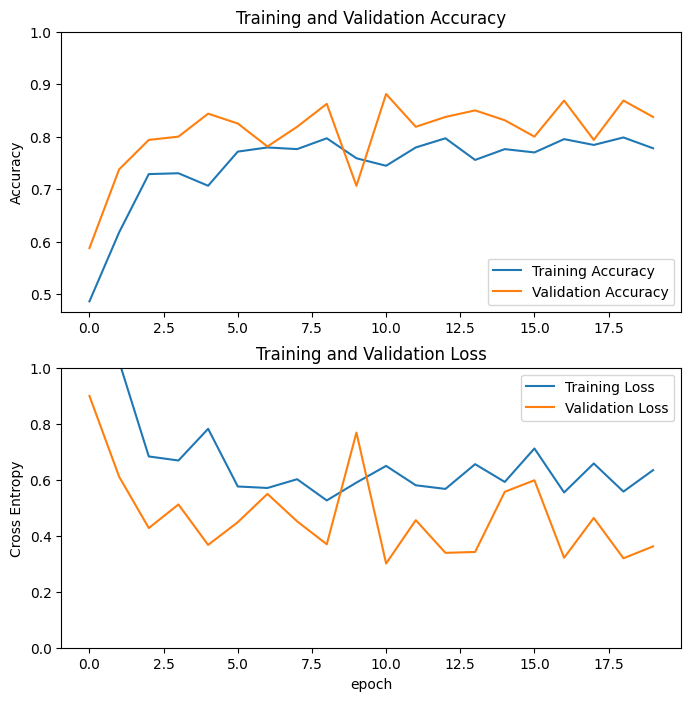

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning the pre-trained model's layers

"Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.
"

(https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning)

In [19]:
modelo_novo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [20]:
mobilenet.trainable = True
modelo_novo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 2227715 (8.50 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [21]:

#Fine-tune from this layer onwards
fine_tune_at = 100 #(mobilenet tem 155 layers)

#Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

for layer in mobilenet.layers:
    if "bn" in layer.name or "BN" in layer.name:
        layer.trainable = False

modelo_novo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 1843459 (7.03 MB)
Non-trainable params: 418368 (1.60 MB)
_________________________________________________________________


#### Training

In [22]:
# Algumas informações dos Layers do modelo
print(f"Trainable: {modelo_novo.trainable}")
print("Number of layers in the base model: ", len(modelo_novo.layers))
print(len(modelo_novo.trainable_variables))

Trainable: True
Number of layers in the base model:  3
20


In [23]:
lr_modelo_novo = 0.0001 # Usar um learning rate menor do que quando só treinou os novos layers
modelo_novo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_modelo_novo),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
loss0, accuracy0 = modelo_novo.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 6s 403ms/step - loss: 0.3605 - accuracy: 0.8385
initial loss: 0.36
initial accuracy: 0.84


In [25]:
# As you are training a much larger model and want to readapt the pretrained weights, it is
# important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
finetune_epochs =  20

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history_ft = modelo_novo.fit(
    train_ds,
    epochs=finetune_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps
)


Epoch 1/20
40/40 [==============================] - 96s 2s/step - loss: 1.0294 - accuracy: 0.6656 - val_loss: 0.3719 - val_accuracy: 0.8500
Epoch 2/20
40/40 [==============================] - 87s 2s/step - loss: 0.5269 - accuracy: 0.7841 - val_loss: 0.5440 - val_accuracy: 0.8062
Epoch 3/20
40/40 [==============================] - 87s 2s/step - loss: 0.4669 - accuracy: 0.8159 - val_loss: 0.5338 - val_accuracy: 0.8000
Epoch 4/20
40/40 [==============================] - 80s 2s/step - loss: 0.4215 - accuracy: 0.8365 - val_loss: 0.2974 - val_accuracy: 0.8813
Epoch 5/20
40/40 [==============================] - 75s 2s/step - loss: 0.3845 - accuracy: 0.8556 - val_loss: 0.1933 - val_accuracy: 0.9250
Epoch 6/20
40/40 [==============================] - 78s 2s/step - loss: 0.3390 - accuracy: 0.8762 - val_loss: 0.4956 - val_accuracy: 0.8438
Epoch 7/20
40/40 [==============================] - 76s 2s/step - loss: 0.4005 - accuracy: 0.8508 - val_loss: 0.5029 - val_accuracy: 0.8250
Epoch 8/20
40/40 [==

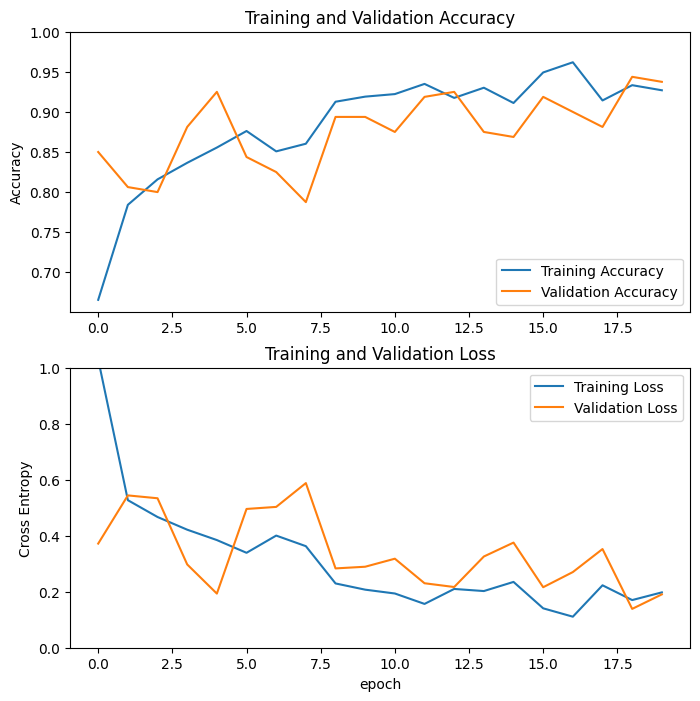

In [26]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Example prediction
( https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub#an_imagenet_classifier )

(512, 512, 3)
float32
1.0


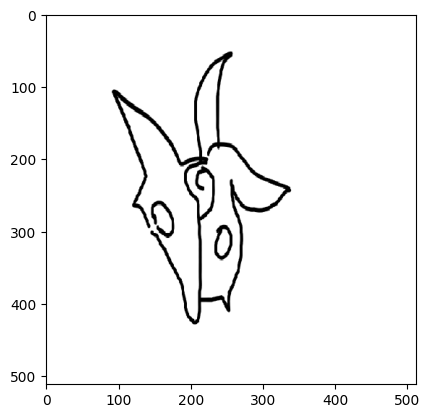

In [ ]:
# img_kindred = tf.keras.utils.get_file('kindred.jpg','https://i.pinimg.com/originals/5e/2e/95/5e2e95e0099f516abe38b8c8e33f715f.jpg')
# img_kindred = Image.open(img_kindred).resize((512,512))
# img_kindred = np.array(img_kindred)/255.0

img_kindred = tf.keras.preprocessing.image.load_img("/content/kindred_drawing.png", target_size=(512,512))
img_kindred = tf.keras.preprocessing.image.img_to_array(img_kindred)
img_kindred = img_kindred/255.0

print(img_kindred.shape)
print(img_kindred.dtype)
print(img_kindred.max())
plt.imshow(img_kindred)

(512, 512, 3)


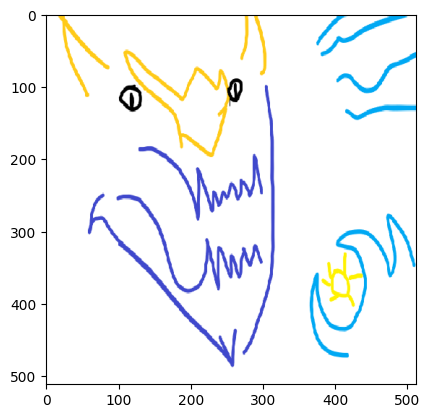

In [ ]:
# img_asol = tf.keras.utils.get_file('aurelion.jpg','https://i.redd.it/lb98gi1ao8s31.jpg')
# img_asol = Image.open(img_asol).resize((224,224))
# img_asol = np.array(img_asol)/255.0

img_asol = tf.keras.preprocessing.image.load_img("/content/asol3.jpg", target_size=(512,512))
img_asol = tf.keras.preprocessing.image.img_to_array(img_asol)
img_asol = img_asol/255.0
#img_asol = tf.expand_dims(img_asol, 0) # Expandir a dimensão antes do predict por conta da dimensão de batch
print(img_asol.shape)
plt.imshow(img_asol)

(512, 512, 3)


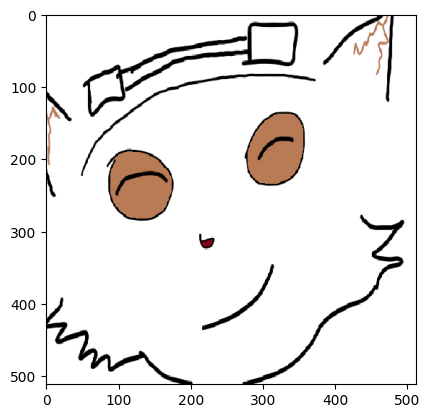

In [ ]:
# img_teemo = tf.keras.utils.get_file('teemo1.jpg','https://pbs.twimg.com/media/EXJv8u9XkAMUu3c.jpg')
# img_teemo = Image.open(img_teemo).resize((224,224))
# img_teemo = np.array(img_teemo)/255.0
# # Converter de (224,224) para (224,224,3) caso necessário
# #img_teemo = img_teemo[..., np.newaxis]
# #img_teemo = tf.image.grayscale_to_rgb(tf.convert_to_tensor(img_teemo))

img_teemo = tf.keras.preprocessing.image.load_img("/content/teemo_drawing.png", target_size=(512,512))
img_teemo = tf.keras.preprocessing.image.img_to_array(img_teemo)
img_teemo = img_teemo/255.0

print(img_teemo.shape)
plt.imshow(img_teemo)

In [ ]:
result = modelo_novo.predict(img_kindred[np.newaxis, ...]) #Add a batch dimension (with np.newaxis) and pass the image to the model:
#print(result.shape) # (1, 3) --> 1 prediction com 3 classes

result = result.squeeze() # squeeze() pois a prediction foi com apenas 1 exemplo

probabilidades = (tf.nn.softmax(result) * 100).numpy()

print("Probabilidades associadas às classes:")
print("[aurelion, kindred, teemo]")
print(probabilidades)

print("Personagem:", class_names[result.argmax()], "- Confiança:", probabilidades[result.argmax()])

1/1 [==============================] - 0s 104ms/step
Probabilidades associadas às classes: (aurelion, kindred, teemo)
[60.611248 27.148804 12.239948]
Personagem: aurelion sol - Confiança: 60.611248


In [ ]:
result = modelo_novo.predict(tf.expand_dims(img_asol, 0))
result = result.squeeze()

probabilidades = (tf.nn.softmax(result) * 100).numpy()

print("Probabilidades associadas às classes:")
print("[aurelion, kindred, teemo]")
print(probabilidades)

print("Personagem:", class_names[result.argmax()], "- Confiança:", probabilidades[result.argmax()])

1/1 [==============================] - 0s 136ms/step
Probabilidades associadas às classes: (aurelion, kindred, teemo)
[98.47927    1.1918986  0.3288293]
Personagem: aurelion sol - Confiança: 98.47927


In [ ]:
result = modelo_novo.predict(img_teemo[np.newaxis, ...])
result = result.squeeze()

probabilidades = (tf.nn.softmax(result) * 100).numpy()

print("Probabilidades associadas às classes:")
print("[aurelion, kindred, teemo]")
print(probabilidades)

print("Personagem:", class_names[result.argmax()], "- Confiança:", probabilidades[result.argmax()])

1/1 [==============================] - 0s 100ms/step
Probabilidades associadas às classes:
[aurelion, kindred, teemo]
[18.02791     0.89759344 81.0745    ]
Personagem: teemo - Confiança: 81.0745


#### Predict a dataset

In [ ]:
test = val_ds.take(1)

In [ ]:
predicoes = modelo_novo.predict(test)
for p in predicoes:
    print("Character:", class_names[p.argmax()])

1/1 [==============================] - 1s 641ms/step
Personagem: teemo
Personagem: teemo
Personagem: kindred
Personagem: kindred
Personagem: aurelion sol
Personagem: kindred
Personagem: kindred
Personagem: aurelion sol
Personagem: aurelion sol
Personagem: teemo
Personagem: kindred
Personagem: kindred
Personagem: teemo
Personagem: teemo
Personagem: aurelion sol
Personagem: kindred


In [ ]:
# for img,label in val_ds.take(3)...
# https://www.tensorflow.org/tutorials/images/transfer_learning#evaluation_and_prediction
i=-1
for img_batch,label_batch in test:
  for img,label in zip(img_batch, label_batch):
    i+=1
    plt.figure(figsize=(3,3))
    plt.imshow(img) # considerar o batch no val_ds.take...
    #plt.title(label)
    print("Personagem:", class_names[predicoes[i].argmax()])
    plt.show()

#### Visualize prediction (not working)
https://www.tensorflow.org/tutorials/keras/classification#make_predictions

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  #true_label= true_label[i]
  #img=img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  #true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


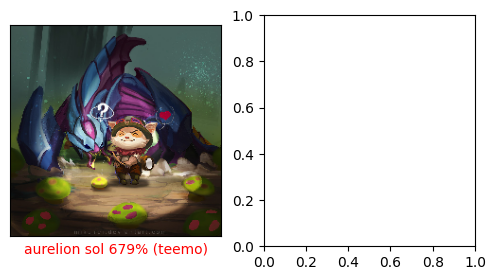

In [ ]:
i = 2
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, result, "teemo", img_teemo)
plt.subplot(1,2,2)
#plot_value_array(i, result,  "teemo")
plt.show()

### Save the weights of the model
To save weights manually, use tf.keras.Model.save_weights. By default, tf.keras—and the Model.save_weights method in particular—uses the TensorFlow Checkpoint format with a .ckpt extension. To save in the HDF5 format with a .h5 extension, refer to the Save and load models guide.
https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Salvar os pesos
modelo_novo.save_weights('/content/pesos_salvos/modelo_novo_weights')

In [ ]:
def create_model():
  model = tf.keras.Sequential([
      mobilenet,
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(
          3,
          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seeder),
          kernel_regularizer=tf.keras.regularizers.l2(0.0001)
      )
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_classification_head),
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )

  return model

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('/content/pesos_salvos/modelo_novo_weights')

# Evaluate the model
loss, acc = model.evaluate(val_ds)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

11/11 [==============================] - 5s 327ms/step - loss: 0.2878 - accuracy: 0.9255
Restored model, accuracy: 92.55%


### Save entire model
https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format

Call tf.keras.Model.save to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (SavedModel and HDF5). The TensorFlow SavedModel format is the default file format in TF2.x. However, models can be saved in HDF5 format. More details on saving entire models in the two file formats is described below.

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p modelos_salvos
modelo_novo.save('modelos_salvos/leaguenet')

In [ ]:
# Contains an assets folder, saved_model.pb, and variables folder.
!ls modelos_salvos/leaguenet

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
teste_load_model = tf.keras.models.load_model('modelos_salvos/leaguenet')

# Check its architecture
teste_load_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 1,843,459
Non-trainable params: 418,368
_________________________________________________________________


In [ ]:
# Evaluate the restored model
loss, acc = teste_load_model.evaluate(val_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
print(teste_load_model.predict(val_ds).shape)

11/11 - 5s - loss: 0.2707 - accuracy: 0.9130 - 5s/epoch - 454ms/step
Restored model, accuracy: 91.30%
11/11 [==============================] - 5s 403ms/step
(161, 3)


In [ ]:
!zip -r /content/leaguenet.zip /content/modelos_salvos/leaguenet

from google.colab import files
files.download("/content/leaguenet.zip")

  adding: content/modelos_salvos/leaguenet/ (stored 0%)
  adding: content/modelos_salvos/leaguenet/assets/ (stored 0%)
  adding: content/modelos_salvos/leaguenet/saved_model.pb (deflated 91%)
  adding: content/modelos_salvos/leaguenet/variables/ (stored 0%)
  adding: content/modelos_salvos/leaguenet/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/modelos_salvos/leaguenet/variables/variables.index (deflated 76%)
  adding: content/modelos_salvos/leaguenet/keras_metadata.pb (deflated 96%)
  adding: content/modelos_salvos/leaguenet/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convert to tfjs model
https://www.tensorflow.org/js/tutorials/conversion/import_saved_model

~~ https://www.tensorflow.org/js/tutorials/conversion/import_keras ~~

In [ ]:
!git clone https://github.com/Jp9910/Projeto-AM
!mv /content/Projeto-AM/model /content/leaguenet_v1.zip
!unzip /content/leaguenet_v1.zip -d leaguenet
!rm -rf /content/Projeto-AM

Cloning into 'Projeto-AM'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 85 (delta 40), reused 70 (delta 28), pack-reused 0
Unpacking objects: 100% (85/85), 25.97 MiB | 8.25 MiB/s, done.


In [ ]:
!unzip /content/leaguenet_v1.zip -d leaguenet

Archive:  /content/leaguenet_v1.zip
   creating: leaguenet/content/modelos_salvos/leaguenet/
   creating: leaguenet/content/modelos_salvos/leaguenet/assets/
  inflating: leaguenet/content/modelos_salvos/leaguenet/saved_model.pb  
   creating: leaguenet/content/modelos_salvos/leaguenet/variables/
  inflating: leaguenet/content/modelos_salvos/leaguenet/variables/variables.data-00000-of-00001  
  inflating: leaguenet/content/modelos_salvos/leaguenet/variables/variables.index  
  inflating: leaguenet/content/modelos_salvos/leaguenet/keras_metadata.pb  
 extracting: leaguenet/content/modelos_salvos/leaguenet/fingerprint.pb  


In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --help

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    /content/leaguenet/content/modelos_salvos/leaguenet \
    /content/tfjs_model


2023-05-07 06:12:04.877000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 06:12:05.948725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-07 06:12:14.045329: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-07 06:12:14.045600: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [ ]:
!zip -r /content/leaguenetJS.zip /content/tfjs_model
from google.colab import files
files.download("/content/leaguenetJS_v1.zip")

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 95%)
  adding: content/tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard1of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>